### Hiato do Produto 

* PIB (Trimestral) - IBGE - sidrapy - Tabela 1621

# Bibliotecas

In [1]:
# Importa bibliotecas
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sidrapy as sidra
from plotnine import *

# Dados

In [2]:
# Importar dados:
# PIB - Preços de mercado - Série encadeada s.a. - Índice (média 1999 = 100)
pib_bruto = sidra.get_table(
                table_code = 1621,
                territorial_level = "1", # alguns argumentos recebem valores padrão
                ibge_territorial_code = "all",
                variable = 'all',
                period = "all",
                classifications = {"11255" : "90707"},
                header = 'n'
                )
pib = (
    pib_bruto
    [['D2C', 'V']]
    .rename(
        columns = {
            "D2C": "data",
            "V": "pib"
            }
            )
     .assign(  # substitui o 5º caracter da coluna data por "-Q" e converte em YYYY-MM-DD
        data = lambda x: pd.PeriodIndex(
            x.data.str.slice_replace(start = 4, stop = 5, repl = "-Q"),
            freq = "Q"
            ).to_timestamp(),
        pib = lambda x: x.pib.astype(float) # converte de texto para numérico
        )
     .loc[lambda x: (x.data >= "1999-01-01") & (x.data <= "2024-12-31")]
     .sort_values("data")
     .reset_index(drop=True)
)

# Rebase para média de 1999 = 100
media_1999 = pib.loc[pib.data.dt.year == 1999, "pib"].mean()
pib["pib"] = (pib["pib"] / media_1999) * 100

# Cria novas colunas auxiliares para o exercício
pib["ln_pib"] = np.log(pib["pib"])  # Transformação logarítmica do PIB
pib["tempo"] = pib.index + 1        # Vetor de 1 até T indicando ordenação tempora das observações

pib.head()

,data,pib,ln_pib,tempo
0,1999-01-01,99.263430,4.597777,1
1,1999-04-01,99.779498,4.602963,2
2,1999-07-01,99.770115,4.602869,3
3,1999-10-01,101.186958,4.616970,4
4,2000-01-01,102.266010,4.627577,5


# Tendência linear

In [3]:
# Regressão linear do PIB contra o tempo
reg1 = smf.ols(
    formula = "ln_pib ~ tempo",  # especificação do modelo no formato de fórmula
    data = pib  # fonte dos dados
    ).fit() # estima o modelo

# Salva a tendência estimada
potencial_tl = np.exp(reg1.predict()) # extrai os valores estimados e reverte a transformação logarítmica
potencial_tl

array([106.77335483, 107.34903331, 107.92781563, 108.5097185 ,
       109.09475875, 109.6829533 , 110.27431916, 110.86887342,
       111.46663328, 112.06761601, 112.671839  , 113.27931972,
       113.89007572, 114.50412467, 115.12148432, 115.74217253,
       116.36620723, 116.99360647, 117.6243884 , 118.25857125,
       118.89617335, 119.53721314, 120.18170916, 120.82968003,
       121.48114451, 122.13612141, 122.79462969, 123.45668837,
       124.1223166 , 124.79153363, 125.46435881, 126.14081158,
       126.82091152, 127.50467827, 128.19213162, 128.88329144,
       129.57817771, 130.27681052, 130.97921008, 131.68539669,
       132.39539077, 133.10921285, 133.82688357, 134.54842368,
       135.27385403, 136.00319562, 136.73646951, 137.47369692,
       138.21489916, 138.96009767, 139.70931397, 140.46256975,
       141.21988678, 141.98128695, 142.74679228, 143.51642491,
       144.29020708, 145.06816117, 145.85030967, 146.6366752 ,
       147.42728049, 148.22214841, 149.02130192, 149.82

# Tendência quadrática

In [4]:
# Regressão linear do PIB contra o tempo + tempo^2
reg2 = smf.ols(
    formula = "ln_pib ~ tempo + np.power(tempo, 2)",  # especificação do modelo no formato de fórmula
    data = pib  # fonte dos dados
    ).fit() # estima o modelo

# Salva a tendência estimada
potencial_tq = np.exp(reg2.predict()) # extrai os valores estimados e reverte a transformação logarítmica
potencial_tq

array([ 95.65602893,  96.7897085 ,  97.9245254 ,  99.06020627,
       100.19647424, 101.33304904, 102.46964707, 103.60598153,
       104.74176252, 105.87669716, 107.01048967, 108.14284156,
       109.27345167, 110.40201636, 111.52822959, 112.65178308,
       113.77236643, 114.88966725, 116.00337132, 117.1131627 ,
       118.2187239 , 119.319736  , 120.41587884, 121.50683111,
       122.59227054, 123.67187406, 124.74531794, 125.81227794,
       126.87242948, 127.92544782, 128.97100817, 130.00878592,
       131.03845675, 132.05969682, 133.07218293, 134.07559272,
       135.06960478, 136.05389885, 137.02815602, 137.99205884,
       138.94529154, 139.88754018, 140.81849281, 141.73783967,
       142.64527334, 143.54048891, 144.42318417, 145.29305974,
       146.14981927, 146.99316963, 147.82282099, 148.63848709,
       149.43988534, 150.22673699, 150.9987673 , 151.75570572,
       152.497286  , 153.22324638, 153.93332975, 154.62728378,
       155.30486106, 155.96581929, 156.60992138, 157.23

# Filtro HP

In [5]:
# Calcula o filtro HP
filtro_hp = sm.tsa.filters.hpfilter(x = pib['ln_pib'], lamb = 1600)

# Salva a tendência calculada
potencial_hp = np.exp(filtro_hp[1]) # posição 1 é a tendência (0=ciclo); reverte a transformação logarítmica
potencial_hp.head()

0     99.260335
1     99.933625
2    100.611484
3    101.293848
4    101.980113
Name: ln_pib_trend, dtype: float64

# Filtro de Hamilton

In [6]:
# Regressão linear aplicando a especificação de Hamilton
reg3 = smf.ols(
    formula = "ln_pib ~ ln_pib.shift(8) + ln_pib.shift(9) + ln_pib.shift(10) + ln_pib.shift(11)",  # especificação do modelo no formato de fórmula
    data = pib  # fonte dos dados
    ).fit() # estima o modelo

# Salva a tendência estimada
potencial_h = np.exp(reg3.predict()) # extrai os valores estimados e reverte a transformação logarítmica

# Adiciona 11 NaNs no início da série para corresponder ao tamanho da série do PIB
potencial_h = np.append([np.nan]*11, potencial_h)
potencial_h

array([         nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan, 110.62478158,
       111.44010517, 113.03345694, 114.1165995 , 115.39323427,
       115.70531707, 115.35878646, 114.78902721, 114.36189481,
       116.71072154, 116.77578304, 118.78793346, 119.3682808 ,
       119.1757259 , 118.42143579, 119.12400888, 119.94871635,
       121.62678743, 124.50267295, 125.78883765, 127.02014452,
       127.76317054, 128.88067339, 128.25042144, 129.83617524,
       131.09258068, 131.83603084, 133.86586879, 134.86837254,
       137.27198276, 139.15101632, 140.54322485, 142.40150486,
       143.76053989, 146.39361365, 148.30008824, 143.83907152,
       142.54845788, 143.38395845, 146.30995754, 150.14613336,
       152.9007044 , 154.72191367, 155.89923516, 157.69484235,
       159.36212195, 160.89577382, 160.64686645, 161.99406065,
       159.6364753 , 162.57861682, 164.04507083, 164.84

# Hiato IFI



In [7]:
# Coleta e tratamento do Hiato do Produto da IFI
hiato_ifi = (
    pd.read_excel(
    "https://www12.senado.leg.br/ifi/dados/arquivos/estimativas-do-hiato-do-produto-ifi.xlsx",
    sheet_name = "Hiato do Produto",
    skiprows = 1
    )
    .assign(data = lambda x: pd.to_datetime(x['Trim-Ano']).dt.to_period('Q'),
            IFI = lambda x: x.Hiato.astype(float) * 100)
    .loc[:, ['data', 'IFI']]
  )

hiato_ifi.head()

,data,IFI
0,1996Q1,-1.32
1,1996Q2,-0.89
2,1996Q3,1.51
3,1996Q4,0.43
4,1997Q1,0.97


# Hiato BCB

In [8]:
# Coleta e tratamento do Hiato do Produto do BCB (Trimestral)
hiato_bcb = (
    pd.read_excel(
    "https://www.bcb.gov.br/content/ri/relatorioinflacao/202509/rpm202509anp.xlsx",
    sheet_name = "Graf 2.2.8",
    skiprows = 8
    )
    .assign(data = lambda x: pd.to_datetime(x['Trimestre']).dt.to_period('Q'),
            BCB = lambda x: x["Cenário de referência"].astype(float))
    .loc[:, ['data', 'BCB']]
    .dropna()
  )

hiato_bcb.head()

,data,BCB
1,2003Q4,-0.99
2,2004Q1,-0.54
3,2004Q2,-0.11
4,2004Q3,0.27
5,2004Q4,0.49


# Calculando o hiato

In [9]:
# Cálculo do hiato do produto
dados = pib[["data", "pib"]].copy()  # seleciona colunas de interesse
dados["Tendência Linear"] = (dados["pib"] / potencial_tl - 1) * 100    # cria novas colunas com cálculo do hiato
dados["Tendência Quadrática"] = (dados["pib"] / potencial_tq - 1) * 100
dados["Filtro HP"] = (dados["pib"] / potencial_hp - 1) * 100
dados["Filtro de Hamilton"] = (dados["pib"] / potencial_h - 1) * 100
dados['data'] = dados.data.dt.to_period('Q')
dados = pd.merge(dados, hiato_ifi, on='data', how='left')
dados = pd.merge(dados, hiato_bcb, on='data', how='left')

In [10]:
dados = dados.drop(columns = ["pib"])  # remove a coluna da série do PIB
dados_long = dados.melt(    # transforma a tabela pro formato "longo" (mais linhas e menos colunas)
    id_vars = ["data"],  # coluna identificadora das observações (todas as demais serão transformadas)
    value_name = "valor", # nome da coluna que armazenará os nomes das colunas transformadas
    var_name = "variavel" # nome da coluna que armazenará os valores das colunas transformadas
    )
dados_long['data'] = dados_long.data.dt.to_timestamp()
dados_long

,data,variavel,valor
0,1999-01-01,Tendência Linear,-7.033520
1,1999-04-01,Tendência Linear,-7.051331
2,1999-07-01,Tendência Linear,-7.558478
3,1999-10-01,Tendência Linear,-6.748484
4,2000-01-01,Tendência Linear,-6.259466
...,...,...,...
619,2023-10-01,BCB,0.470000
620,2024-01-01,BCB,0.710000
621,2024-04-01,BCB,0.950000
622,2024-07-01,BCB,1.140000


In [26]:
# Cores para gráficos
colors = {'blue': "#747cca",
          'yellow': "#67e279",
          'red'   : "#000000",
          'green': "#ff480b88",
          'gray': "#F32020",
          'green_two' : "#5e31d1"
          }

/home/fernando/Documentos/dev/brazil-taylor-determinacy/artmacro2/lib/python3.12/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 19 rows containing missing values.


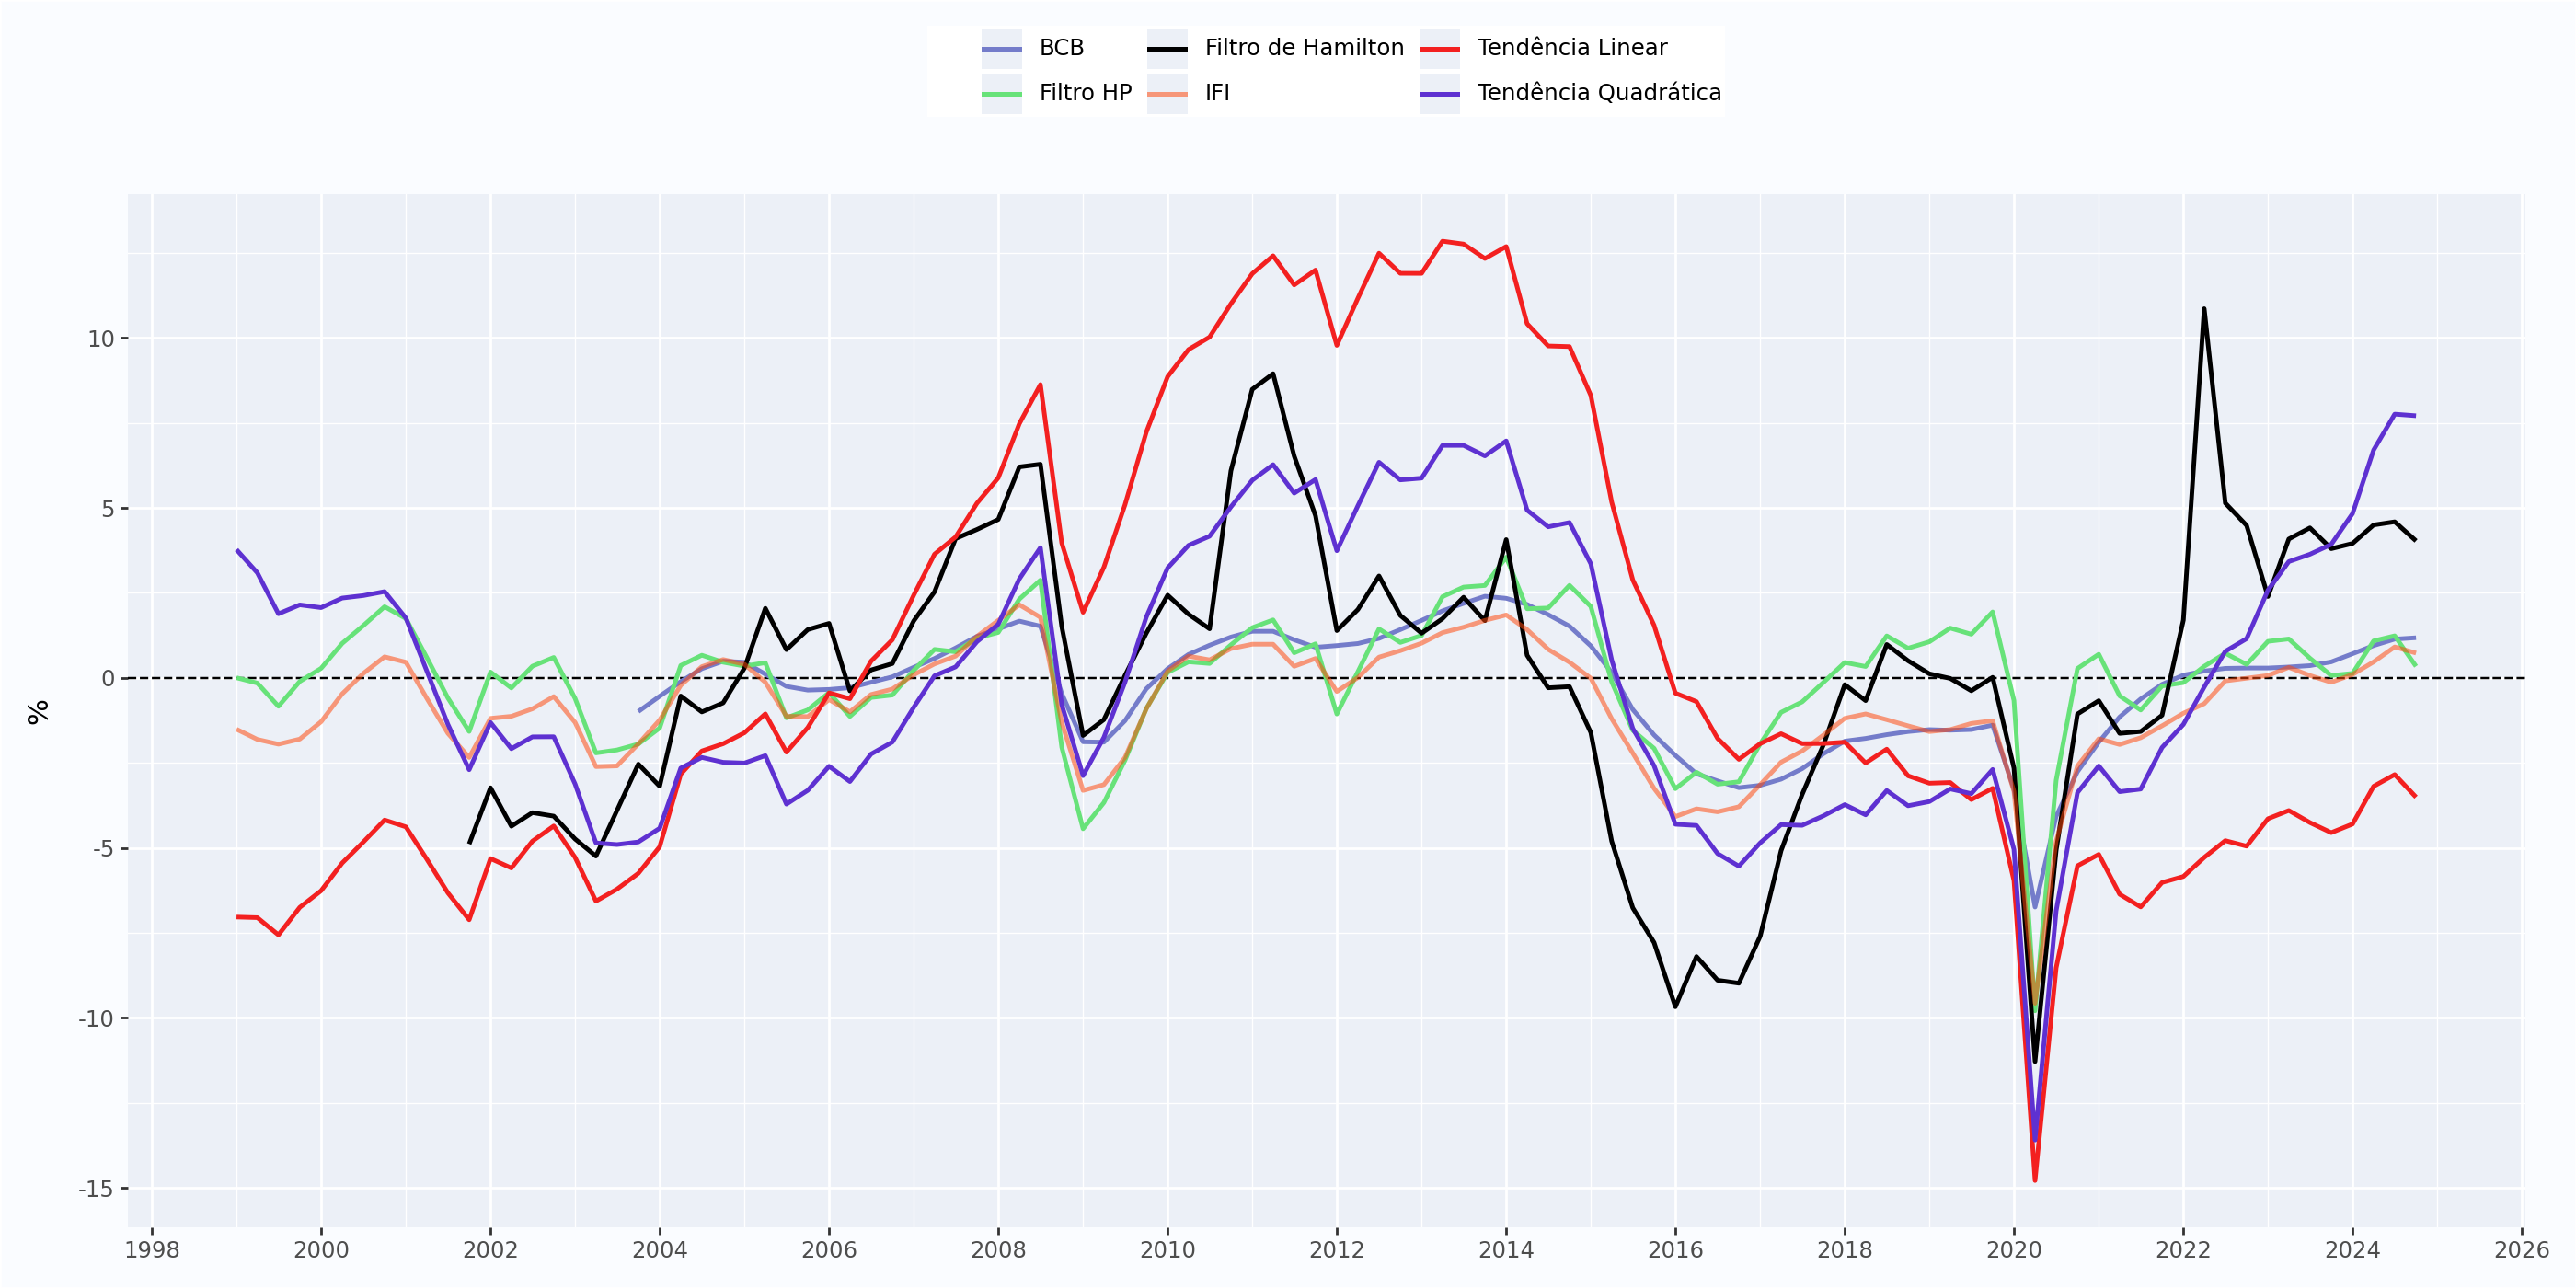

In [34]:
grafico_hiato = (
    ggplot(dados_long) +
    aes(x='data', y='valor', color='variavel') +
    geom_hline(yintercept=0, linetype="dashed") +
    geom_line(size=1) +
    scale_color_manual(values=list(colors.values())) +
    scale_x_date(date_breaks = "2 years", date_labels = "%Y") +
    theme(legend_position='top',
          figure_size=(14, 7),
          panel_background=element_rect(fill="#ECF0F7"),
          plot_background=element_rect(fill='#FAFCFF')) +
    labs(
        # title="Hiato do Produto - Brasil",
        # subtitle="Cálculos do autor a partir do PIB encadeado dessazonalidado (média 1999 = 100)",
        y="%",
        x='',
        color=""
        # caption="Fonte: IBGE, BCB, IFI \n Nota: hiatos medido como a diferença % do PIB efetivo em relação ao potencial."
    )
)
grafico_hiato

In [35]:
# Exportar o gráfico para /home/fernando/Documentos/dev/brazil-taylor-determinacy/paper/graficos/hiato_produto.png
grafico_hiato.save(
    filename = "/home/fernando/Documentos/dev/brazil-taylor-determinacy/paper/graficos/hiato_produto.png",
    dpi = 300
    ) # type: ignore

/home/fernando/Documentos/dev/brazil-taylor-determinacy/artmacro2/lib/python3.12/site-packages/plotnine/ggplot.py:623: PlotnineWarning: Saving 14 x 7 in image.
/home/fernando/Documentos/dev/brazil-taylor-determinacy/artmacro2/lib/python3.12/site-packages/plotnine/ggplot.py:624: PlotnineWarning: Filename: /home/fernando/Documentos/dev/brazil-taylor-determinacy/paper/graficos/hiato_produto.png
/home/fernando/Documentos/dev/brazil-taylor-determinacy/artmacro2/lib/python3.12/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 19 rows containing missing values.


## Estatística Descritivas dos Hiatos



In [13]:
dados.describe()

,Tendência Linear,Tendência Quadrática,Filtro HP,Filtro de Hamilton,IFI,BCB
count,104.000000,104.000000,104.000000,93.000000,104.000000,85.000000
mean,0.214262,0.083480,0.016705,0.090397,-0.819423,-0.264706
std,6.663592,4.102126,1.816306,4.252716,1.728831,1.697518
min,-14.782081,-13.591256,-9.789709,-11.282942,-9.570000,-6.740000
25%,-4.953473,-3.266832,-0.738433,-1.967810,-1.700000,-1.520000
50%,-2.016555,-0.827425,0.339929,0.290108,-0.700000,0.160000
75%,5.143897,3.660817,1.077431,2.432698,0.460000,0.960000
max,12.841388,7.755229,3.548670,10.856603,2.150000,2.400000
